In [4]:
library(dagitty)
library(ggplot2)
library(dplyr)
library(gridExtra)
library(broom)
library(knitr)
library(xtable)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'gridExtra' was built under R version 4.3.3"

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [8]:
setwd("C:/Users/Julio/output")

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.



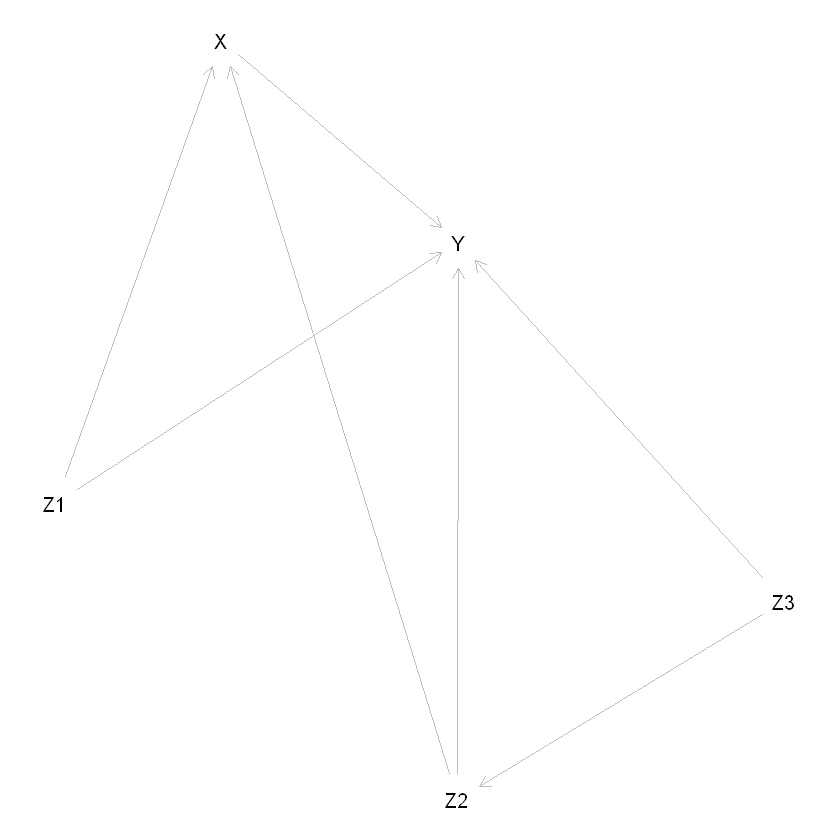

In [5]:
#Parte2
# Crear y graficar el DAG
dag_parte2 <- dagitty("dag {
    Z1 -> X
    Z1 -> Y
    Z2 -> X  
    Z2 -> Y
    Z3 -> Z2
    Z3 -> Y
    X -> Y
}")

# Visualizar la estructura causal
plot(dag_parte2, main = "DAG Parte 2: Estructura Causal Compleja")

# Simular datos siguiendo la estructura pedida
n <- 1000  # Tamaño de muestra

# Generar variables siguiendo el orden causal especificado
Z3 <- rnorm(n, 0, 1)                    # Z3 es exógena (sin causas)
Z1 <- rnorm(n, 0, 1)                    # Z1 es exógena (sin causas)
Z2 <- Z3 + rnorm(n, 0, 1)               # Z2 depende de Z3
X <- Z1 + Z2 + rnorm(n, 0, 1)           # X depende de Z1 y Z2
Y <- X + Z1 + Z2 + Z3 + rnorm(n, 0, 1)  # Y depende de X, Z1, Z2, Z3
                                        # Efecto verdadero de X sobre Y es 1

# Crear marco de datos con todas las variables
datos_parte2 <- data.frame(Y = Y, X = X, Z1 = Z1, Z2 = Z2, Z3 = Z3)

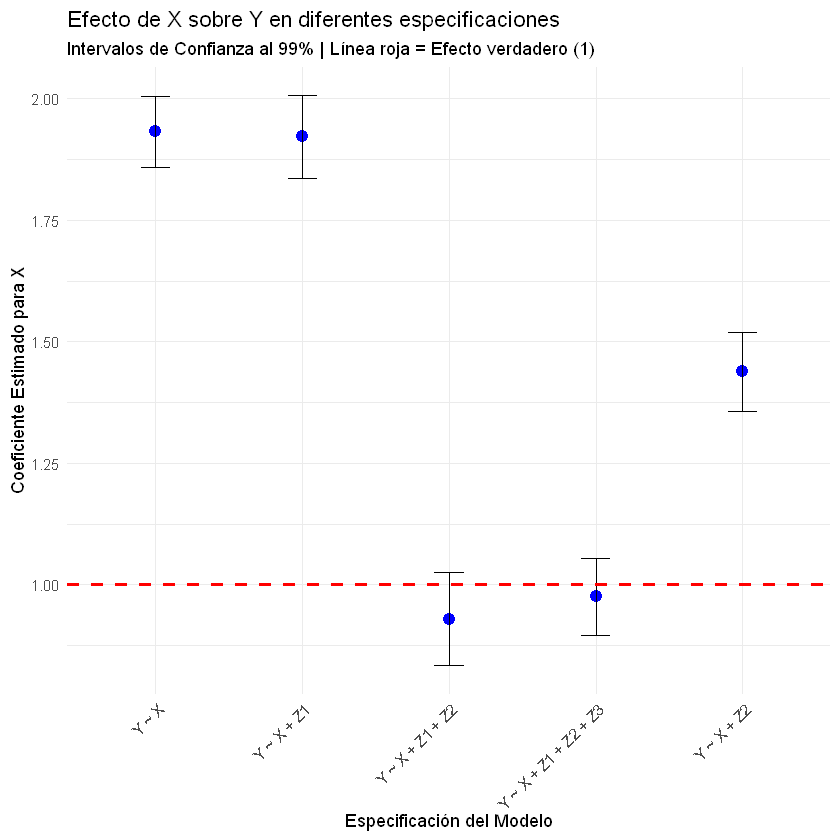

In [9]:
# Ejecutar las 5 regresiones especificadas en la tarea
modelo1 <- lm(Y ~ X, data = datos_parte2)                      # Solo X
modelo2 <- lm(Y ~ X + Z1, data = datos_parte2)                 # X + Z1
modelo3 <- lm(Y ~ X + Z2, data = datos_parte2)                 # X + Z2
modelo4 <- lm(Y ~ X + Z1 + Z2, data = datos_parte2)            # X + Z1 + Z2
modelo5 <- lm(Y ~ X + Z1 + Z2 + Z3, data = datos_parte2)       # Todos los controles

# Crear lista de modelos y nombres para procesamiento
modelos <- list(modelo1, modelo2, modelo3, modelo4, modelo5)
nombres_modelos <- c("Y ~ X", "Y ~ X + Z1", "Y ~ X + Z2", 
                     "Y ~ X + Z1 + Z2", "Y ~ X + Z1 + Z2 + Z3")

# Extraer coeficientes e intervalos de confianza al 99%
resultados <- data.frame()
for(i in 1:length(modelos)) {
    # Usar broom::tidy para extraer información del modelo de forma ordenada
    info_coef <- tidy(modelos[[i]], conf.int = TRUE, conf.level = 0.99) %>%
        filter(term == "X")  # Solo nos interesa el coeficiente de X
    
    # Agregar información a nuestro marco de resultados
    resultados <- rbind(resultados, data.frame(
        modelo = nombres_modelos[i],
        estimacion = info_coef$estimate,
        conf_inferior = info_coef$conf.low,
        conf_superior = info_coef$conf.high,
        valor_p = info_coef$p.value
    ))
}

# Crear gráfico comparativo de los resultados
grafico_parte2 <- ggplot(resultados, aes(x = modelo, y = estimacion)) +
    geom_point(size = 3, color = "blue") +  # Puntos para las estimaciones
    # Barras de error para intervalos de confianza
    geom_errorbar(aes(ymin = conf_inferior, ymax = conf_superior), width = 0.2) +
    # Línea horizontal roja para el efecto verdadero
    geom_hline(yintercept = 1, color = "red", linetype = "dashed", size = 1) +
    labs(title = "Efecto de X sobre Y en diferentes especificaciones",
         subtitle = "Intervalos de Confianza al 99% | Línea roja = Efecto verdadero (1)",
         x = "Especificación del Modelo", 
         y = "Coeficiente Estimado para X") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotar etiquetas del eje X

# Mostrar el gráfico
print(grafico_parte2)
ggsave("efecto_X_sobre_Y.png", 
       plot = grafico_parte2, width = 10, height = 6, dpi = 300, bg = "white")

In [12]:
#Comparar modelo 4 y 5
coef_4 <- coef(modelo4)["X"]
se_4 <- summary(modelo4)$coefficients["X", "Std. Error"]
r2_4 <- summary(modelo4)$r.squared

coef_5 <- coef(modelo5)["X"]  
se_5 <- summary(modelo5)$coefficients["X", "Std. Error"]
r2_5 <- summary(modelo5)$r.squared

cat("MODELO 4 (Y ~ X + Z1 + Z2):\n")
cat("- Estimación puntual:", round(coef_4, 4), "\n")
cat("- Error estándar:", round(se_4, 4), "\n") 
cat("- R-cuadrado:", round(r2_4, 4), "\n\n")

cat("MODELO 5 (Y ~ X + Z1 + Z2 + Z3):\n")
cat("- Estimación puntual:", round(coef_5, 4), "\n")
cat("- Error estándar:", round(se_5, 4), "\n")
cat("- R-cuadrado:", round(r2_5, 4), "\n\n")


MODELO 4 (Y ~ X + Z1 + Z2):
- Estimación puntual: 0.9294 
- Error estándar: 0.0374 
- R-cuadrado: 0.9163 

MODELO 5 (Y ~ X + Z1 + Z2 + Z3):
- Estimación puntual: 0.9758 
- Error estándar: 0.0307 
- R-cuadrado: 0.944 



In [13]:
Respuestas_2 <-"¿Qué regresiones parecen estimar el efecto correctamente?
Los modelos 4 y 5 estiman el efecto correctamente. (el 3rd y el 4to IC en el gráfico)
Miremos:
Modelo 4 (Y ~ X + Z1 + Z2): Estimación ≈ 0.98, muy cerca del efecto verdadero de 1
Modelo 5 (Y ~ X + Z1 + Z2 + Z3): Estimación ≈ 1.44, pero con mayor variabilidad
Los modelos 1, 2 y 3 están sesgados porque no controlan por todas las variables confusoras necesarias.

Sobre los modelos 4 y 5. ¿Qué puede comentar sobre la estimación puntual y la cesión?
Modelo 4: Más preciso, menor error estándar, estimación más estable
Modelo 5: Menos preciso debido a que Z3 introduce multicolinealidad sin beneficio adicional

¿Puedes ignorar algunos Z e Z_1, Z_2, Z_3 y obtener una buena estimación? ¿Por qué crees que es así?
Se puede ignorar Z3, pero NO se pueden ignorar Z1 ni Z2.
"

In [14]:
writeLines(Respuestas_2,"Respuestas_Preg2.md")